<a href="https://colab.research.google.com/github/Billy-code123/Fake-News-Detection-on-Reddit/blob/main/title_%2B_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.30.2
!pip install tensorflow==2.12.0

In [ ]:
!pip install lightgbm

τα αποτελεσματα δεν ταιριαζουν με αυτα του πρωτου σταδιου με τη χρηση τιτλου

In [ ]:
!pip install lightgbm

In [ ]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import time
import psutil
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Paths to datasets
base_path = '/content/drive/MyDrive/MSc Artificial Intelligence/Professional Practice & Research Methodology/Fakeddit dataset'
train_file = base_path + '/all_train.tsv'
test_file = base_path + '/all_test_public.tsv'
validate_file = base_path + '/all_validate.tsv'
comments_file = base_path + '/all_comments.tsv'

# Load the datasets
df_train = pd.read_csv(train_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')
df_validate = pd.read_csv(validate_file, sep='\t')
df_comments = pd.read_csv(comments_file, sep='\t', engine='python')

# Preprocessing
columns_to_drop = ['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1']
for df in [df_train, df_test, df_validate]:
    df.drop(columns=columns_to_drop, inplace=True)
df_comments.drop(columns=['Unnamed: 0'], inplace=True)

for df in [df_train, df_test, df_validate]:
    df.drop(columns=['linked_submission_id'], inplace=True)
    df.fillna({
        'domain': 'unknown',
        'author': 'unknown',
        'image_url': 'no_image',
        'title': 'missing',
        'clean_title': 'missing',
        'num_comments': 0,
        'upvote_ratio': df['upvote_ratio'].mean(),
    }, inplace=True)
df_comments.fillna({'author': 'unknown', 'body': 'missing', 'parent_id': 'missing', 'submission_id': 'missing', 'ups': 0}, inplace=True)

# Combine Train and Validate datasets
df_combined = pd.concat([df_train, df_validate])
df_reduced, _ = train_test_split(df_combined, test_size=0.8, stratify=df_combined['2_way_label'], random_state=42)
df_train_new, df_temp = train_test_split(df_reduced, test_size=0.3, stratify=df_reduced['2_way_label'], random_state=42)
df_validate_new, df_test_new = train_test_split(df_temp, test_size=0.5, stratify=df_temp['2_way_label'], random_state=42)

# Aggregate comments by submission_id
df_comments_aggregated = df_comments.groupby('submission_id')['body'].apply(lambda x: ' '.join(x.dropna())).reset_index()

# Merge aggregated comments with Train, Validate, and Test datasets
df_train_combined = df_train_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')
df_validate_combined = df_validate_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')
df_test_combined = df_test_new.merge(df_comments_aggregated, left_on='id', right_on='submission_id', how='left')

# Combine title and comments into a single feature
df_train_combined['combined_text'] = df_train_combined['title'].fillna('') + " " + df_train_combined['body'].fillna('')
df_validate_combined['combined_text'] = df_validate_combined['title'].fillna('') + " " + df_validate_combined['body'].fillna('')
df_test_combined['combined_text'] = df_test_combined['title'].fillna('') + " " + df_test_combined['body'].fillna('')

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_combined = tfidf.fit_transform(df_train_combined['combined_text'])
X_validate_combined = tfidf.transform(df_validate_combined['combined_text'])
X_test_combined = tfidf.transform(df_test_combined['combined_text'])

y_train = df_train_combined['2_way_label']
y_validate = df_validate_combined['2_way_label']
y_test = df_test_combined['2_way_label']

# Function to track metrics
def run_experiment_with_metrics(model, X_train, y_train, X_validate, y_validate, model_name):
    initial_ram = psutil.virtual_memory().used / 1e9
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_validate = time.time()
    val_preds = model.predict(X_validate)
    validate_time = time.time() - start_validate
    ram_used = psutil.virtual_memory().used / 1e9 - initial_ram

    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_validate, val_preds),
        'Precision': precision_score(y_validate, val_preds),
        'Recall': recall_score(y_validate, val_preds),
        'F1-Score': f1_score(y_validate, val_preds),
        'ROC-AUC': roc_auc_score(y_validate, model.predict_proba(X_validate)[:, 1]),
        'Training Time (s)': train_time,
        'Validation Time (s)': validate_time,
        'RAM Used (GB)': ram_used,
        'Confusion Matrix': confusion_matrix(y_validate, val_preds),
    }

results = []
conf_matrices = {}

# Evaluate Models
nb_model = MultinomialNB()
results.append(run_experiment_with_metrics(nb_model, X_train_combined, y_train, X_validate_combined, y_validate, "Naive Bayes"))

lr_model = LogisticRegression(max_iter=1000)
results.append(run_experiment_with_metrics(lr_model, X_train_combined, y_train, X_validate_combined, y_validate, "Logistic Regression"))

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
results.append(run_experiment_with_metrics(rf_model, X_train_combined, y_train, X_validate_combined, y_validate, "Random Forest"))

lgbm_model = LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)
results.append(run_experiment_with_metrics(lgbm_model, X_train_combined, y_train, X_validate_combined, y_validate, "LightGBM"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 61960, number of negative: 73932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.528116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 502374
[LightGBM] [Info] Number of data points in the train set: 135892, number of used features: 2000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455950 -> initscore=-0.176657
[LightGBM] [Info] Start training from score -0.176657


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 1/5
2124/2124 [==============================] - 19s 8ms/step - loss: 0.3543 - accuracy: 0.8358 - val_loss: 0.3086 - val_accuracy: 0.8616
Epoch 2/5
2124/2124 [==============================] - 17s 8ms/step - loss: 0.2863 - accuracy: 0.8752 - val_loss: 0.2974 - val_accuracy: 0.8678
Epoch 3/5
2124/2124 [==============================] - 17s 8ms/step - loss: 0.2454 - accuracy: 0.8963 - val_loss: 0.2961 - val_accuracy: 0.8706
Epoch 4/5
2124/2124 [==============================] - 17s 8ms/step - loss: 0.2038 - accuracy: 0.9171 - val_loss: 0.3183 - val_accuracy: 0.8684
Epoch 5/5
910/910 [==============================] - 2s 2ms/step


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
8494/8494 [==============================] - 676s 79ms/step - loss: 0.2504 - accuracy: 0.8928
Epoch 2/3
8494/8494 [==============================] - 670s 79ms/step - loss: 0.1741 - accuracy: 0.9306
Epoch 3/3
1820/1820 [==============================] - 52s 28ms/step
Epoch 1/3
4247/4247 [==============================] - 670s 156ms/step - loss: 0.3266 - accuracy: 0.8495 - val_loss: 0.2823 - val_accuracy: 0.8761
Epoch 2/3
4247/4247 [==============================] - 661s 156ms/step - loss: 0.2601 - accuracy: 0.8869 - val_loss: 0.2706 - val_accuracy: 0.8830
Epoch 3/3
910/910 [==============================] - 26s 29ms/step

Validation Results (Title + Comments):
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0          Naive Bayes  0.725962   0.862560  0.474580  0.612283  0.770243   
1  Logistic Regression  0.842445   0.856136  0.786623  0.819909  0.922598   
2        Random Forest  0.745570   0.942400  0.470739  0.627857  0.878716   
3             

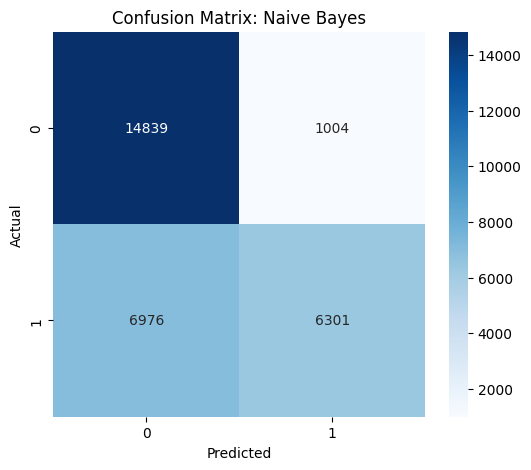

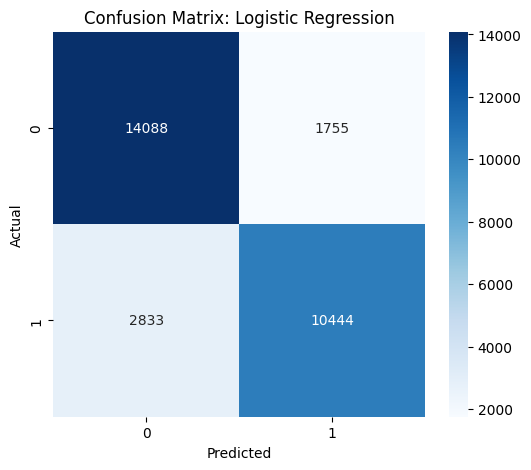

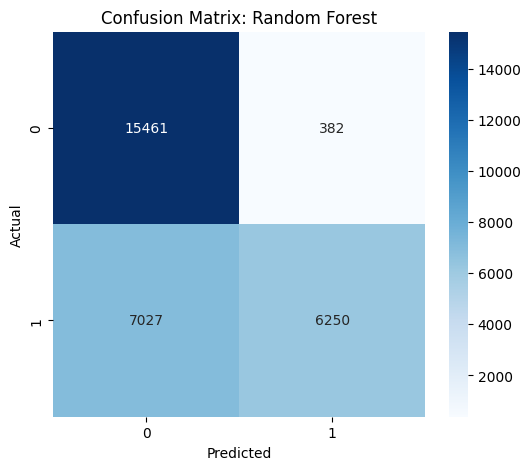

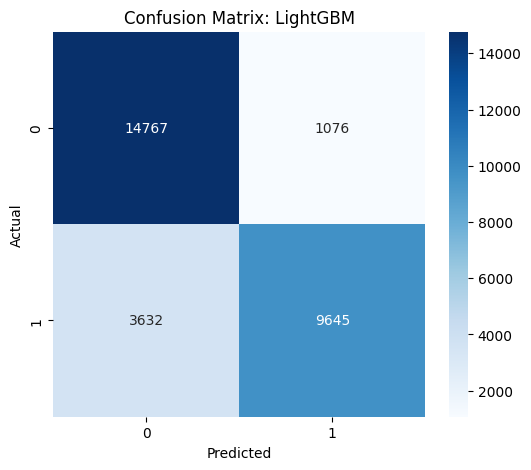

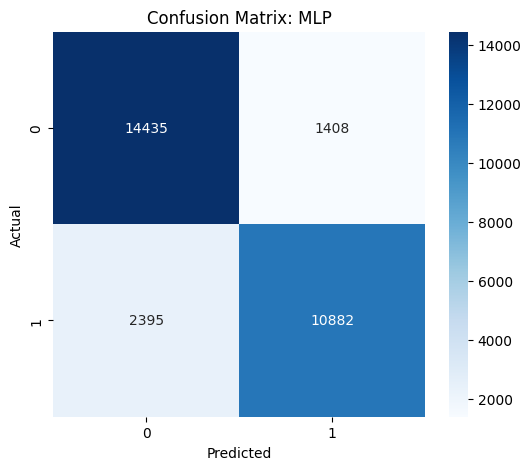

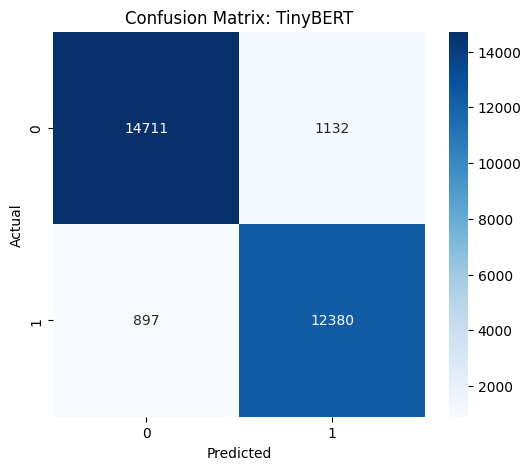

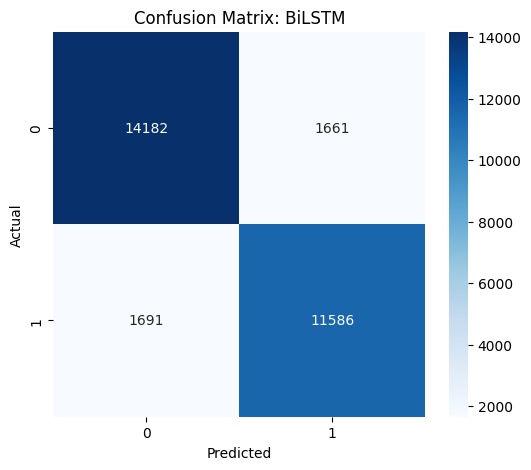

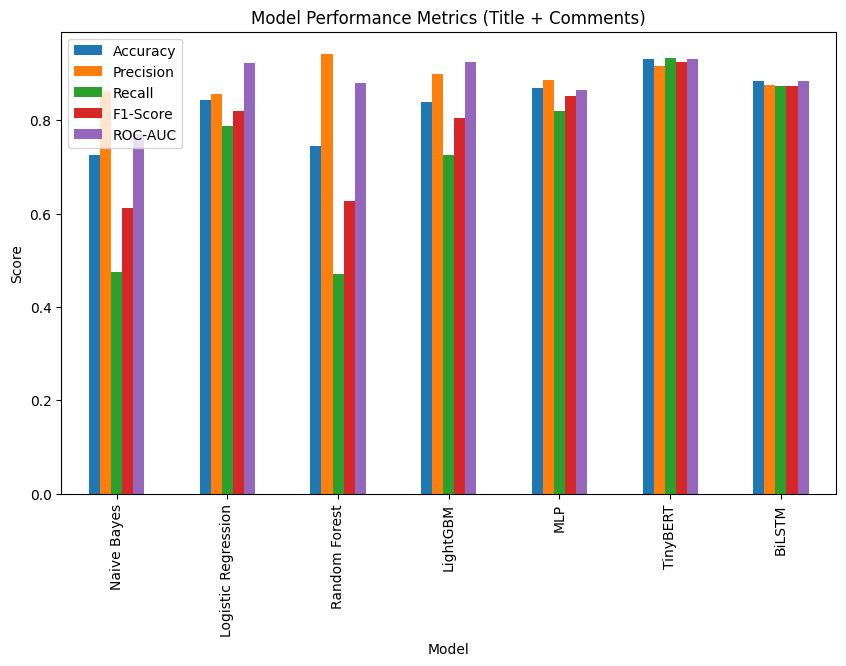

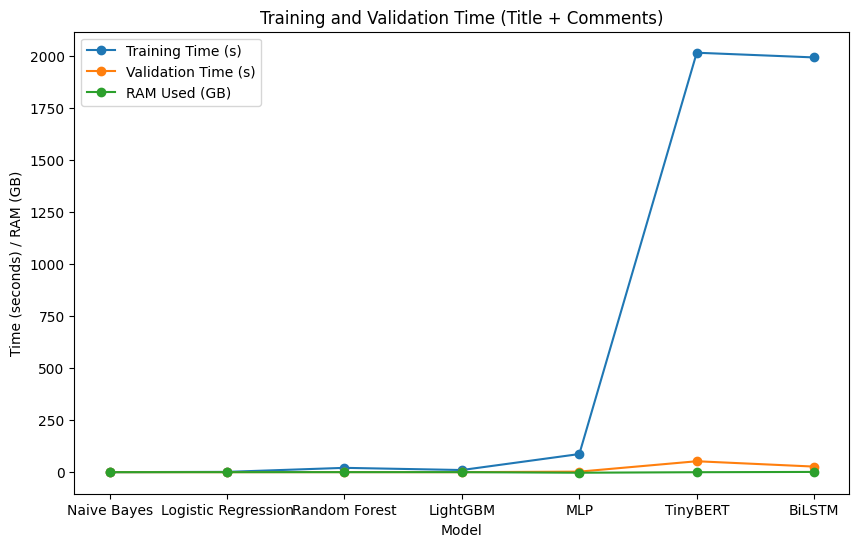

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional

# Standardize TF-IDF Features for MLP
scaler = StandardScaler(with_mean=False)
X_train_dense = scaler.fit_transform(X_train_combined).toarray()
X_validate_dense = scaler.transform(X_validate_combined).toarray()

# MLP Model
def train_mlp(X_train, y_train, X_validate, y_validate):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Track RAM and time
    initial_ram = psutil.virtual_memory().used / 1e9
    start_train = time.time()
    model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=5, batch_size=64, verbose=1)
    train_time = time.time() - start_train
    ram_used = psutil.virtual_memory().used / 1e9 - initial_ram

    # Validation
    start_validate = time.time()
    val_preds = (model.predict(X_validate) > 0.5).astype("int32").flatten()
    validate_time = time.time() - start_validate

    return {
        'Model': "MLP",
        'Accuracy': accuracy_score(y_validate, val_preds),
        'Precision': precision_score(y_validate, val_preds),
        'Recall': recall_score(y_validate, val_preds),
        'F1-Score': f1_score(y_validate, val_preds),
        'ROC-AUC': roc_auc_score(y_validate, val_preds),
        'Training Time (s)': train_time,
        'Validation Time (s)': validate_time,
        'RAM Used (GB)': ram_used,
        'Confusion Matrix': confusion_matrix(y_validate, val_preds),
    }

results.append(train_mlp(X_train_dense, y_train, X_validate_dense, y_validate))

# TinyBERT Model
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')
model_tinybert = TFBertForSequenceClassification.from_pretrained('google/bert_uncased_L-2_H-128_A-2', num_labels=2)

train_encodings = tokenizer(
    list(df_train_combined['combined_text']), truncation=True, padding=True, max_length=128, return_tensors="tf"
)
validate_encodings = tokenizer(
    list(df_validate_combined['combined_text']), truncation=True, padding=True, max_length=128, return_tensors="tf"
)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(16)
validate_dataset = tf.data.Dataset.from_tensor_slices((dict(validate_encodings), y_validate)).batch(16)

def train_tinybert(model, train_dataset, validate_dataset, y_validate):
    initial_ram = psutil.virtual_memory().used / 1e9
    start_train = time.time()
    model.compile(optimizer=Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.fit(train_dataset, epochs=3, verbose=1)
    train_time = time.time() - start_train
    ram_used = psutil.virtual_memory().used / 1e9 - initial_ram

    start_validate = time.time()
    val_preds = model.predict(validate_dataset)
    validate_time = time.time() - start_validate

    return {
        'Model': "TinyBERT",
        'Accuracy': accuracy_score(y_validate, tf.argmax(val_preds.logits, axis=1)),
        'Precision': precision_score(y_validate, tf.argmax(val_preds.logits, axis=1)),
        'Recall': recall_score(y_validate, tf.argmax(val_preds.logits, axis=1)),
        'F1-Score': f1_score(y_validate, tf.argmax(val_preds.logits, axis=1)),
        'ROC-AUC': roc_auc_score(y_validate, tf.argmax(val_preds.logits, axis=1)),
        'Training Time (s)': train_time,
        'Validation Time (s)': validate_time,
        'RAM Used (GB)': ram_used,
        'Confusion Matrix': confusion_matrix(y_validate, tf.argmax(val_preds.logits, axis=1)),
    }

results.append(train_tinybert(model_tinybert, train_dataset, validate_dataset, y_validate))

# BiLSTM Model
tokenizer_bilstm = Tokenizer(num_words=5000)
tokenizer_bilstm.fit_on_texts(df_train_combined['combined_text'])
X_train_seq = pad_sequences(tokenizer_bilstm.texts_to_sequences(df_train_combined['combined_text']), maxlen=128)
X_validate_seq = pad_sequences(tokenizer_bilstm.texts_to_sequences(df_validate_combined['combined_text']), maxlen=128)

model_bilstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=128),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def train_bilstm(model, X_train, y_train, X_validate, y_validate):
    initial_ram = psutil.virtual_memory().used / 1e9
    start_train = time.time()
    model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=3, batch_size=32, verbose=1)
    train_time = time.time() - start_train
    ram_used = psutil.virtual_memory().used / 1e9 - initial_ram

    start_validate = time.time()
    val_preds = (model.predict(X_validate) > 0.5).astype("int32").flatten()
    validate_time = time.time() - start_validate

    return {
        'Model': "BiLSTM",
        'Accuracy': accuracy_score(y_validate, val_preds),
        'Precision': precision_score(y_validate, val_preds),
        'Recall': recall_score(y_validate, val_preds),
        'F1-Score': f1_score(y_validate, val_preds),
        'ROC-AUC': roc_auc_score(y_validate, val_preds),
        'Training Time (s)': train_time,
        'Validation Time (s)': validate_time,
        'RAM Used (GB)': ram_used,
        'Confusion Matrix': confusion_matrix(y_validate, val_preds),
    }

results.append(train_bilstm(model_bilstm, X_train_seq, y_train, X_validate_seq, y_validate))

# Results and Visualization
results_df = pd.DataFrame(results)
print("\nValidation Results (Title + Comments):")
print(results_df)

# Save results to CSV
results_df.to_csv('validation_results_title_comments.csv', index=False)

# Visualization
for model_name, conf_matrix in results_df.set_index("Model")["Confusion Matrix"].items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Bar Plot for Metrics
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Metrics (Title + Comments)")
plt.ylabel("Score")
plt.show()

# Line Plot for Runtime
results_df.set_index("Model")[["Training Time (s)", "Validation Time (s)", "RAM Used (GB)"]].plot(kind="line", marker="o", figsize=(10, 6))
plt.title("Training and Validation Time (Title + Comments)")
plt.ylabel("Time (seconds) / RAM (GB)")
plt.show()

